In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

C:\Users\eliza\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\eliza\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

# Чтение данных

In [340]:
file1=pd.read_csv("Close.csv")
x=file1.drop('Unnamed: 0', axis=1).to_numpy()
y=file1.loc[:,['Unnamed: 0']].values

In [4]:
file2=pd.read_csv("High.csv")
high=file2.drop('Unnamed: 0', axis=1).to_numpy()
y=file1.loc[:,['Unnamed: 0']].values

In [5]:
file3=pd.read_csv("Low.csv")
low=file3.drop('Unnamed: 0', axis=1).to_numpy()
y=file1.loc[:,['Unnamed: 0']].values

In [6]:
file4=pd.read_csv("Open.csv")
op=file4.drop('Unnamed: 0', axis=1).to_numpy()
y=file1.loc[:,['Unnamed: 0']].values

In [7]:
file5=pd.read_csv("Volume.csv")
volume=file4.drop('Unnamed: 0', axis=1).to_numpy()
y=file1.loc[:,['Unnamed: 0']].values

# Фильтрация цены

In [8]:
#k -скачок цены
def value_filt(mass,i):
    if (abs(10*mass[i]/mass[i-1] -1)<0.1 and abs(10*mass[i]/mass[i+1] -1)<0.1):
        return (10*mass[i]/mass[i-1] -1)
    if abs(mass[i]/(10*mass[i-1]) -1)<0.1:
        return (mass[i]/(10*mass[i-1]) -1)
    if (abs(100*mass[i]/mass[i-1] -1)<0.1 and abs(100*mass[i]/mass[i+1] -1)<0.1):
        return (100*mass[i]/mass[i-1] -1)
    if abs(mass[i]/(100*mass[i-1]) -1)<0.1:
        return (mass[i]/(100*mass[i-1]) -1)
    else: 
        return (mass[i]/mass[i-1] -1)

In [9]:
def build_filt(x): #на входе передается данные - массив n*m
    n=x.shape[0]
    m=x.shape[1]
    filt=np.zeros((n, m))
    count=0
    for i in range(n):
        for j in range(1,m-1):
            filt[i, j]=value_filt(x[i],j)
    return filt[:, 1:]

In [10]:
def build_sharpe(list_pnl):
    sharpe=np.zeros(len(list_pnl))
    for i in range(5):
        sharpe[i]=(252)**(1/2)*(list_pnl[250*i:250*(i+1)].mean())/list_pnl[250*i:250*(i+1)].std()
    return sharpe

In [30]:
def build_pnl_by_alpha_new(alpha,filt):
    pnl=np.zeros((len(alpha), 1))
    for i in range (1257-2):
        pnl[i]=alpha[i]@(filt.transpose())[i+1]
    build_graph(pnl)
    return pnl

In [610]:
def build_turnover(alpha_d):
    turnover=np.zeros(len(alpha_d))
    for i in range(1,len(alpha_d)):
    #print(alpha[i])
        turnover[i]=np.linalg.norm(alpha_d[i]-alpha_d[i-1], ord=1)*100
    plt.title('Turnover')    
    plt.plot(turnover)
    plt.show()

# Построение альфы

Нормализация

In [11]:
def build_alpha(v):
    return ((v-v.mean())/(np.linalg.norm(v-v.mean(), ord=1)))

С помощью pca

In [12]:
pca = PCA(n_components=1)

Фильтр по резким скачкам цены

In [13]:
filt=build_filt(x)
new_filt=filt.transpose()
for i in range(len(new_filt)):
    for j in range(len(new_filt[i])):
        if (new_filt[i][j]>0.1):
            new_filt[i][j]=0.1
        if new_filt[i][j]<-0.05:
            new_filt[i][j]=-0.05

In [14]:
x.shape

(2436, 1257)

In [15]:
days=filt.shape[1]
n=filt.shape[0]
pnl=np.zeros((days, 1))
alpha=np.zeros((1, 2436))
alphas=np.zeros((days, 2436))
for i in range (20, days-2):
    comp=pca.fit(new_filt[i-20:i,:]).components_
    for j in  range(1):
        alpha[j]=build_alpha(comp[j])
        alphas[i, :]=alpha[j]
        pnl[i][j]=alphas[j]@(filt.transpose()[i+1])

In [16]:
comp[0]

array([0.01340184, 0.03643868, 0.03613491, ..., 0.01280444, 0.05836675,
       0.00584016])

In [17]:
pnl=np.zeros((1257, 1))
alpha=np.zeros((1, 2436))
alphas=np.zeros((1257, 2436))
for i in range (20, 1257-2):
    comp=pca.fit(new_filt[i-20:i,:]).components_
    for j in  range(1):
        alpha[j]=build_alpha(comp[j])
        alphas[i, :]=alpha[j]
        pnl[i][j]=alpha[j]@(filt.transpose())[i+1]

In [18]:
def build_pnl_by_alpha(alpha):
    pnl=np.zeros((len(alpha), 1))
    for i in range (20, 1257-2):
        for j in  range(1):
            pnl[i][j]=alpha[j]@(filt.transpose())[i+1]
    build_graph(pnl)

In [683]:
def build_pca(new_filt, filt, days, companies):
    pnl=np.zeros((days, 1))
    alpha=np.zeros((1, companies))
    alphas=np.zeros((days, companies))
    for i in range (20, days-2):
        comp=pca.fit(new_filt[i-20:i,:]).components_
        for j in  range(1):
            alpha[j]=build_alpha(comp[j])
            alphas[i, :]=alpha[j]
            pnl[i][j]=alpha[j]@(filt.transpose())[i+1]
    build_graph(pnl)
    return alphas

In [20]:
def build_graph(array):
    plt.title('Graphic')
    plt.plot(np.cumsum(array))
    plt.show()

In [21]:
def build_turnover(alpha_d):
    turnover=np.zeros(len(alpha_d))
    for i in range(len(alpha_d)):
        turnover[i]=np.linalg.norm(alpha_d[i]-alpha_d[i-1], ord=1)*100
    plt.plot(turnover)
    plt.show()
    return turnover

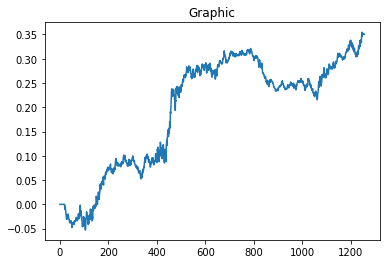

In [684]:
pca_alpha=build_pca(new_filt, filt, 1257, 2436)

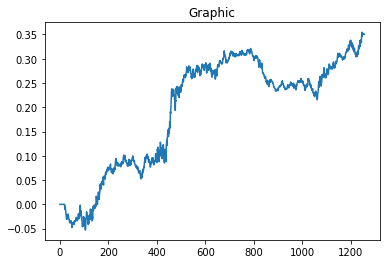

In [686]:
pca_pnl=build_pnl_by_alpha_new(pca_alpha, filt)

# Задача 4

Alpha decay

In [687]:
alpha_d=np.zeros((len(alphas), len(alphas[0])))
for i in range(5):
    for j in range(len(alphas[0])):
        alpha_d[i][j]=alphas[i][j]
for i in range(4,len(alphas)):
    #for j in range(len(alphas[0])):
    alpha_d[i]=1*alphas[i]+(1/2)*alphas[i-1]+(1/3)*alphas[i-2]+(1/4)*alphas[i-3]+(1/5)*alphas[i-4]
    alpha_d[i]=build_alpha(alpha_d[i])

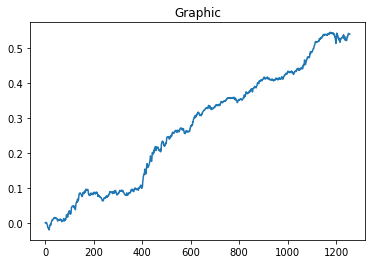

In [692]:
decay_pnl=build_pnl_by_alpha_new(alpha_d, filt)

close(d − 5) − close(d − 1)) / close(d − 1).

In [674]:
def reversion_alpha(filt):
    filt=filt.transpose()
    n=filt.shape[0]
    m=filt.shape[1]
    alpha=np.zeros((n,m))
    for d in range(5,n):
        for i in range(m):
            alpha[d, i]=(filt[d-5,i]-filt[d-1, i])/(filt[d-1, i])
    alpha[d]=build_alpha(alpha[d])
    return alpha

In [675]:
rev_alpha=reversion_alpha(x)

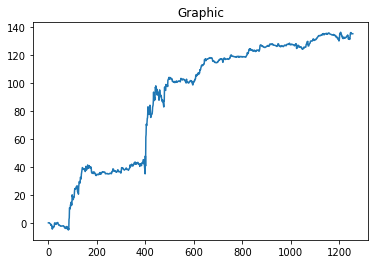

In [676]:
rev_pnl=build_pnl_by_alpha_new(rev_alpha,filt)

volatility reversion

In [38]:
def vol_rev(high, low):
    high=high.transpose()
    low=low.transpose()
    vol=np.zeros((len(high),len(high[0])))
    alphas=np.zeros((1257, 2436))
    for i in range(len(low)):
        for j in range(len(high[0])):
            vol[i][j]=(high[i][j]-low[i][j])/((high[i][j]+low[i][j]))
        alphas[i, :]=build_alpha(vol[i])
        #print(build_alpha(vol[i]))
    return vol, alphas

In [39]:
vol_rev, rev_vol_alpha=vol_rev(high, low)

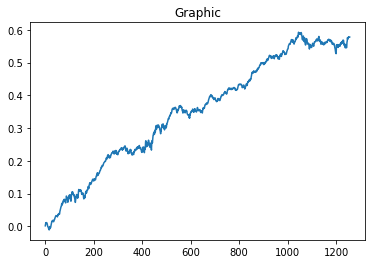

In [677]:
vol_rev_pnl=build_pnl_by_alpha_new(rev_vol_alpha,filt)

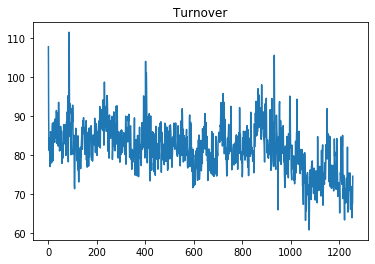

In [42]:
build_turnover(rev_vol_alpha)

high + low − 2close

In [660]:
def high_close(high, close,low):
    high=high.transpose()
    close=close.transpose()
    low=low.transpose()
    vol=np.zeros((len(high),len(high[0])))
    alphas=np.zeros((1257, 2436))
    for i in range(len(low)):
        for j in range(len(high[0])):
            vol[i][j]=(high[i][j]+low[i][j]- 2*close[i][j])/((high[i][j]+low[i][j]))
        alphas[i, :]=build_alpha(vol[i])
    return alphas, vol 

In [661]:
medium_alpha,vol=high_close(high, low, x)

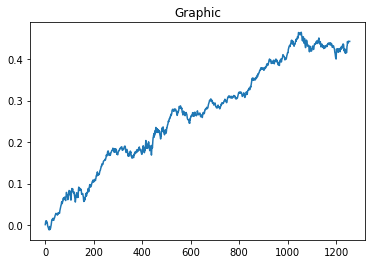

In [667]:
medium_pnl=build_pnl_by_alpha_new(medium_alpha,filt)

open/close

In [47]:
import math

In [48]:
np.nan_to_num(op)
op[op==0]=0.00001

In [49]:
def open_close(op,close):
    op=op.transpose()
    close=close.transpose()
    alphas=np.zeros((len(close),len(close[0])))
    vol=np.zeros((len(close),len(close[0])))
    for i in range(1,len(close)):
        for j in range(len(close[0])):
            vol[i][j]=op[i-1][j]/close[i-1][j]
        alphas[i, :]=build_alpha(vol[i])
    return alphas, vol

In [50]:
alphas, oc=open_close(op, x)

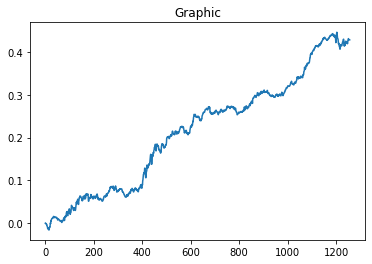

In [51]:
pnl_first=build_pnl_by_alpha_new(alphas, filt)

Корреляция volume and close

In [194]:
corr_vol_close=np.corrcoef(volume,x)
#volume-file

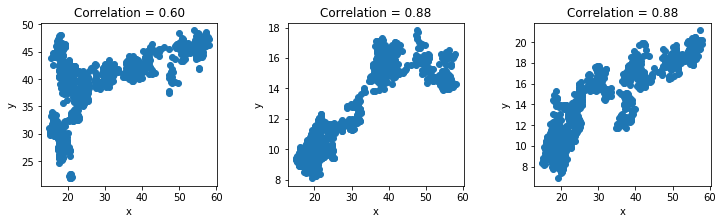

In [195]:
rho = corr_vol_close

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
for i in [0,1,2]:
    ax[i].scatter(x[0,],x[1+i,])
    ax[i].title.set_text('Correlation = ' + "{:.2f}".format(rho[0,i+1]))
    ax[i].set(xlabel='x',ylabel='y')
fig.subplots_adjust(wspace=.4)    
plt.show()

Rank_ts

ts_rank(returns, 20)

In [54]:
def rank(mat):
    order = mat.argsort(axis=1)
    ranks = order.argsort(axis=1)
    return ranks

In [77]:
def build_rank(filt):
    alpha_rank=np.zeros((len(filt.transpose()),2436))
    for i in range(20, len(filt.transpose())):
        ranks=rank(filt[:, i-20:i])
        alpha_rank[i]=build_alpha(ranks[:,-1])
    return alpha_rank

In [78]:
close_rank=build_rank(filt)

In [79]:
close_rank.shape

(1256, 2436)

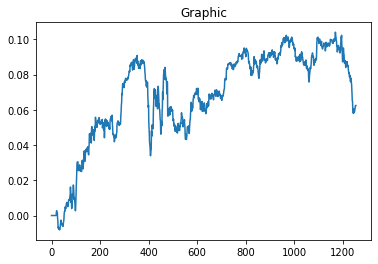

In [84]:
pnl_close_rank=build_pnl_by_alpha_new(close_rank,filt)

ts_rank(volume, 20)

In [669]:
volume_rank=vol_rank=build_rank(volume)

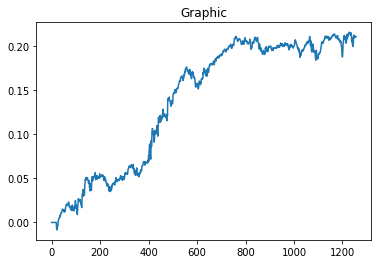

In [670]:
pnl_volume_rank=build_pnl_by_alpha_new(volume_rank,filt)

# Задача 5. KNN

In [85]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(filt)

In [86]:
distances, indices = nbrs.kneighbors(filt)

In [87]:
matrix=nbrs.kneighbors_graph(filt).toarray()
matrix.shape

(2436, 2436)

# Задача 6. Price momentum

In [88]:
def build_momentum(close):
    r=np.zeros(len(close))
    momentum_alpha=np.zeros((len(close), len(close[0])))
    for day in range(273,len(close)):
        for company in range(len(close[0])):
            momentum_alpha[day][company]=(close[day-40:day-20, company].mean())/(close[day-273:day-253,company].mean())
        momentum_alpha[day]=build_alpha(momentum_alpha[day])
    return momentum_alpha

In [152]:
alpha_momentum=build_momentum(filt)

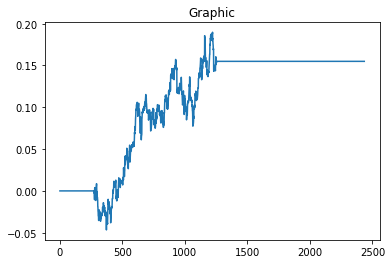

In [522]:
pnl_momentum=build_pnl_by_alpha_new(alpha_momentum,filt.transpose())

# Задача 8-9. Портфели

x[i]=L[i]*weight
summ(x[i])=1

Лучше всего работающие альфы: alpha_momentum, medium_alpha, rev_vol_alpha, pca_alpha, volume_rank

weight_1=1/4
weight_2=sharpe

Text(0, 0.5, 'pnl')

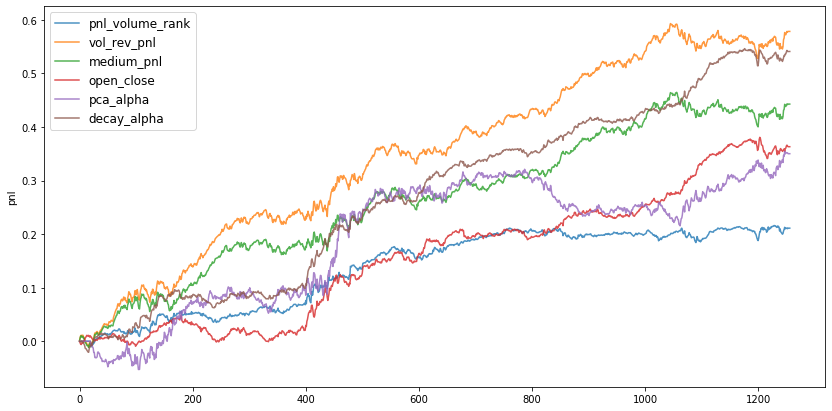

In [696]:
plt.figure(figsize=(14, 7))
plt.plot(np.cumsum(pnl_volume_rank),  alpha=0.8, label="pnl_volume_rank")
plt.plot(np.cumsum(vol_rev_pnl),  alpha=0.8, label="vol_rev_pnl")
plt.plot(np.cumsum(medium_pnl),  alpha=0.8, label="medium_pnl")
plt.plot(np.cumsum(pnl_first),  alpha=0.8, label="open_close")
plt.plot(np.cumsum(pca_pnl),  alpha=0.8, label="pca_alpha")
plt.plot(np.cumsum(decay_pnl),  alpha=0.8, label="decay_alpha")
plt.legend(fontsize=12)
plt.ylabel('pnl')

# Портфель с весом sharpe

In [127]:
days=1257
companies=2436
matrix=filt.transpose()

In [439]:
alphas_sharpe=build_sharpe(alphas)[:5]
med_sharpe=build_sharpe(medium_alpha)[:5]
rev_sh=build_sharpe(rev_vol_alpha)[:5]
vol_sharpe=build_sharpe(volume_rank)[:5]
sum_sharpe=vol_sharpe+rev_sh+med_sharpe+alphas_sharpe
alphas_sharpe=alphas_sharpe/sum_sharpe
rev_sh=rev_sh/sum_sharpe
vol_sharpe=vol_sharpe/sum_sharpe
med_sharpe=med_sharpe/sum_sharpe

In [449]:
summ_alpha=np.zeros(( len(alphas), len(alphas[0]) ))
case=np.zeros((1257, 2436))
for i in range(days):
    for j in range(companies):
        summ_alpha[i][j]=alphas[i][j]*alphas_sharpe[i//252]+rev_vol_alpha[i][j]*rev_sh[i//252]+medium_alpha[i][j]*med_sharpe[i//252]+volume_rank[i][j]*vol_sharpe[i//252]
    case[i]=build_alpha(summ_alpha[i])

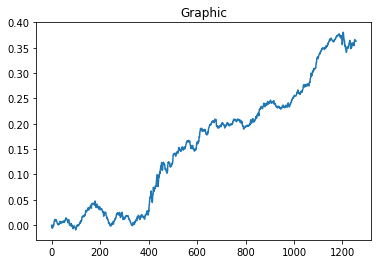

In [450]:
pnl_first=build_pnl_by_alpha_new(case, filt)

In [614]:
build_sharpe(case)

array([ 2.41982702e-17, -3.57448374e-18, -3.38245473e-18, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

# Портфель с весом 1/n

In [465]:
alpha_n=np.zeros((days,companies))
for i in range(days):
    alpha_n[i]=build_alpha(medium_alpha[i]+volume_rank[i]+rev_vol_alpha[i]+alphas[i])

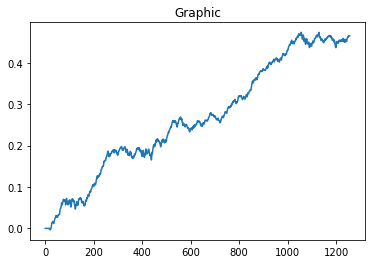

In [468]:
pnl_n=build_pnl_by_alpha(alpha_n)

In [615]:
build_sharpe(alpha_n)

array([ 1.88014292e-17, -3.89872141e-18, -8.04061863e-18, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

# Портфель Марковица

In [897]:
list_pnl = np.vstack((np.cumsum(pnl_volume_rank), np.cumsum(vol_rev_pnl), np.cumsum(medium_pnl),np.cumsum(pnl_first)))
alpha_list=np.vstack((medium_alpha,volume_rank,rev_vol_alpha,alphas))
C = np.cov(list_pnl)
min_risk = 1
max_s = -1
coefs = np.zeros(len(list_pnl))
for i in range(len(list_pnl)):
        weights = np.exp(np.random.randn(4))
        weights = weights/ weights.sum()
        R_n=0
        for i in range(len(list_pnl)):
            R_n = R_n + np.mean(list_pnl[i])*weights[i]
        risk = np.sqrt(np.matmul(np.matmul(weights, C),weights))
        max_sharp = R_n/Risk
        if (risk < min_risk):
            min_risk = risk
            coefs = weights
            if (max_sharp > max_s):
                max_s = max_sharp
                coefs = weights

In [898]:
mark_alpha=np.zeros((days, companies))
for i in range(days): 
    mark_alpha[i]=build_alpha(medium_alpha[i]*coefs[0]+volume_rank[i]*coefs[1]+rev_vol_alpha[i]*coefs[2]+alphas[i]*coefs[3])

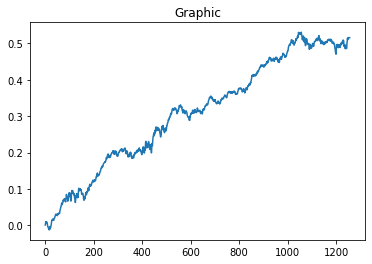

In [899]:
mark_pnl=build_pnl_by_alpha_new(mark_alpha, filt)

# Через Бета

в среднем доходность каждой акции стремится к доходности всего рынка.

In [344]:
pd.DataFrame(np.corrcoef(filt))

,0,1,2,3,4,5,6,7,8,9,...,2426,2427,2428,2429,2430,2431,2432,2433,2434,2435
0,1.000000,0.115150,0.166811,0.111790,0.161507,0.128067,0.104893,0.165784,0.168275,0.140375,...,0.151920,0.124648,0.158371,0.229715,0.082511,0.157964,0.219327,0.162520,0.137517,0.244838
1,0.115150,1.000000,0.252128,0.256909,0.328559,0.344255,0.172443,0.294213,0.307367,0.194784,...,0.244626,0.306110,0.297138,0.311888,0.155659,0.283002,0.401711,0.328641,0.280604,0.364845
2,0.166811,0.252128,1.000000,0.429526,0.444367,0.388576,0.249401,0.467375,0.441466,0.264842,...,0.240130,0.465938,0.316984,0.324839,0.205538,0.348645,0.389297,0.482634,0.268359,0.398014
3,0.111790,0.256909,0.429526,1.000000,0.489554,0.407160,0.248704,0.483655,0.430482,0.268624,...,0.331437,0.418672,0.338703,0.383599,0.219341,0.364942,0.433108,0.557286,0.314347,0.496905
4,0.161507,0.328559,0.444367,0.489554,1.000000,0.462912,0.297721,0.540349,0.491488,0.297359,...,0.332551,0.505657,0.387221,0.458130,0.262545,0.387470,0.489527,0.578810,0.318723,0.531927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,0.157964,0.283002,0.348645,0.364942,0.387470,0.319800,0.206303,0.394944,0.383151,0.298731,...,0.239771,0.363380,0.362297,0.374348,0.168931,1.000000,0.367323,0.431672,0.216079,0.389122
2432,0.219327,0.401711,0.389297,0.433108,0.489527,0.639765,0.247419,0.468194,0.452764,0.336144,...,0.372083,0.424829,0.368985,0.498358,0.247361,0.367323,1.000000,0.531480,0.490307,0.563593
2433,0.162520,0.328641,0.482634,0.557286,0.578810,0.518252,0.319427,0.595353,0.511529,0.304205,...,0.371914,0.545559,0.408676,0.486328,0.279998,0.431672,0.531480,1.000000,0.342075,0.548732
2434,0.137517,0.280604,0.268359,0.314347,0.318723,0.525748,0.166226,0.326929,0.330338,0.227562,...,0.232065,0.262274,0.218623,0.284452,0.161271,0.216079,0.490307,0.342075,1.000000,0.336310


In [351]:
weights=np.random.random(companies)
weights = weights/np.sum(weights)
sum(weights)

0.9999999999999996

Ожидаемая доходность

In [370]:
print(filt.shape)
print(case.shape)
weights

(2436, 1256)
(1257, 2436)


array([9.36693061e-05, 5.41721636e-04, 5.92983599e-04, ...,
       6.72998542e-04, 4.13738110e-04, 2.80384861e-04])

In [512]:
R_f=sum(weights * filt.mean())*250
R_f

0.23645016509424815

Ожидаемое стандартное отклонение(volatility)

In [363]:
np.sqrt(np.dot(weights.T, np.dot(np.cov(filt) * 250, weights)))

0.1696980937247441

Нахождение оптимальных весов

In [901]:
np.random.seed(42)
e_rn = []#ожидаемая доходность
std_dev = []#волотильность
all_weights=[]


for i in range(100):
    weights = np.random.random(companies)
    weights = weights/ weights.sum()
    e_rn.append((weights * filt.mean()).sum() * 250)
    std_dev.append(np.sqrt(np.dot(weights.T, np.dot(np.cov(filt) * 250, weights))))
    all_weights.append(weights)

e_rn = np.array(e_rn) 
std_dev= np.array(std_dev)
df = pd.DataFrame({ "Expected Return": e_rn, "Standard deviation": std_dev})
df.head()

,Expected Return,Standard deviation
0,0.23645,0.170308
1,0.23645,0.172371
2,0.23645,0.171723
3,0.23645,0.170126
4,0.23645,0.170939


plt.figure(figsize=(14,10 ), dpi=80)
plt.scatter(df["Standard deviation"], df["Expected Return"])
plt.xlabel("Standard deviation")
plt.ylabel("Expected return (in %)")
#plt.show()

In [902]:
df[(df["Expected Return"]>0.135)].sort_values(by=['Expected Return']).sort_values(by=['Standard deviation'])

,Expected Return,Standard deviation
89,0.23645,0.169263
72,0.23645,0.169488
84,0.23645,0.169570
77,0.23645,0.169575
16,0.23645,0.169606
...,...,...
81,0.23645,0.172739
14,0.23645,0.172781
87,0.23645,0.172782
98,0.23645,0.172930


In [903]:
print(df.loc[89])
print(all_weights[89])

Expected Return       0.236450
Standard deviation    0.169263
Name: 89, dtype: float64
[1.87552836e-04 5.24918403e-04 2.55088762e-04 ... 1.88702848e-04
 9.48426627e-05 2.44314029e-04]


In [904]:
file1['Unnamed: 0']

0        iba.us
1        wpz.us
2       flic.us
3        ncs.us
4        gpk.us
         ...   
2431    roic.us
2432     nbl.us
2433     atu.us
2434      co.us
2435     apf.us
Name: Unnamed: 0, Length: 2436, dtype: object

In [906]:
weigh=all_weights[89]
pd.DataFrame({"Company": file1['Unnamed: 0'], "Weights": weigh})

,Company,Weights
0,iba.us,0.000188
1,wpz.us,0.000525
2,flic.us,0.000255
3,ncs.us,0.000641
4,gpk.us,0.000316
...,...,...
2431,roic.us,0.000168
2432,nbl.us,0.000601
2433,atu.us,0.000189
2434,co.us,0.000095


In [711]:
#Портфельная теория Марковица говорит, что мы все берем в лонг, поэтому нужно просто взять акции с этими весами

# Через Beta

Построение Beta

In [569]:
print("Матрица ковариаций доходности инструментов")
pd.DataFrame(np.cov(filt))

Матрица ковариаций доходности инструментов


,0,1,2,3,4,5,6,7,8,9,...,2426,2427,2428,2429,2430,2431,2432,2433,2434,2435
0,0.000280,0.000027,0.000046,0.000051,0.000060,0.000065,0.000038,0.000067,0.000039,0.000048,...,0.000053,0.000051,0.000030,0.000048,0.000045,0.000027,0.000067,0.000051,0.000065,0.000043
1,0.000027,0.000201,0.000059,0.000100,0.000104,0.000147,0.000053,0.000101,0.000060,0.000056,...,0.000072,0.000106,0.000047,0.000055,0.000072,0.000040,0.000104,0.000087,0.000112,0.000054
2,0.000046,0.000059,0.000275,0.000195,0.000165,0.000195,0.000089,0.000188,0.000102,0.000089,...,0.000082,0.000189,0.000059,0.000067,0.000112,0.000058,0.000118,0.000150,0.000125,0.000069
3,0.000051,0.000100,0.000195,0.000748,0.000300,0.000337,0.000147,0.000321,0.000163,0.000149,...,0.000187,0.000280,0.000103,0.000130,0.000197,0.000101,0.000216,0.000286,0.000242,0.000142
4,0.000060,0.000104,0.000165,0.000300,0.000500,0.000313,0.000144,0.000293,0.000153,0.000135,...,0.000154,0.000277,0.000096,0.000127,0.000192,0.000088,0.000200,0.000243,0.000201,0.000124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,0.000027,0.000040,0.000058,0.000101,0.000088,0.000098,0.000045,0.000097,0.000054,0.000061,...,0.000050,0.000090,0.000041,0.000047,0.000056,0.000102,0.000068,0.000082,0.000061,0.000041
2432,0.000067,0.000104,0.000118,0.000216,0.000200,0.000352,0.000097,0.000207,0.000115,0.000125,...,0.000140,0.000189,0.000075,0.000113,0.000148,0.000068,0.000332,0.000182,0.000252,0.000107
2433,0.000051,0.000087,0.000150,0.000286,0.000243,0.000294,0.000129,0.000271,0.000133,0.000116,...,0.000144,0.000250,0.000085,0.000113,0.000172,0.000082,0.000182,0.000352,0.000181,0.000108
2434,0.000065,0.000112,0.000125,0.000242,0.000201,0.000448,0.000101,0.000223,0.000129,0.000130,...,0.000135,0.000181,0.000069,0.000099,0.000149,0.000061,0.000252,0.000181,0.000794,0.000099


In [780]:
Beta=np.zeros((companies, companies))
for i in range(companies):
    Beta[i]=np.cov(filt[i,:])/(np.std(filt))
#pd.DataFrame(np.sum(Beta, axis=1))

In [781]:
Beta.mean()

0.021218522621506867

In [909]:
weigh=((Beta*weigh)@filt).transpose()+alpha_n[:-1,:]
for i in range(len(weigh)):
    weigh[i]=build_alpha(weigh[i])

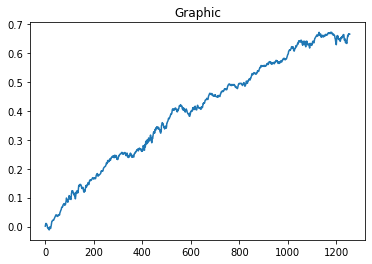

In [911]:
pnl_beta=build_pnl_by_alpha_new(weigh,filt)

In [914]:
build_sharpe(pnl_beta)

array([2.00793675, 1.00275975, 1.52482457, ..., 0.        , 0.        ,
       0.        ])